<a href="https://colab.research.google.com/github/selimsivad49/study/blob/main/colab_de_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab で Kaggle (N番煎じ)
https://zenn.dev/mst8823/articles/da505dcf45474f

In [1]:
## Config
# 最初に，notebookで行う実験やその他諸々の設定をします．

class Config:
    name = "baseline-001"
    only_inference = False  # 学習はせず，推論だけ実行するなら True

    model_name = "roberta-base"
    learning_rate = 1e-5
    max_length = 256
    epochs = 8
    batch_size = 16

    n_fold = 5  # 5fold cross validation
    # [0]を指定すると，最初のfoldを予測対象とした学習のみ行われます
    trn_fold = [0, 1, 2, 3, 4]
    seed = 2022
    target_col = "target"   # 目的変数名
    debug = False

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/kaggle.json"
    drive_path = "/content/drive/MyDrive/CommonLit-Readability-Prize"
    
    # Kaggle Env
    kaggle_dataset_path = None

In [2]:
## Library
# 次に notebook 内で使うライブラリをインポートします．

import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import backend as K

https://github.com/ghmagazine/kagglebook/blob/master/ch04-model-interface/code/util.py

https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5

In [3]:
## Utils
# 便利な関数たちを用意しておきます．と言っても今回は2つだけでした．

class Logger:
    # 参考) https://github.com/ghmagazine/kagglebook/blob/master/ch04-model-interface/code/util.py
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    

def seed_everything(seed=42):
    # 参考) https://qiita.com/kaggle_grandmaster-arai-san/items/d59b2fb7142ec7e270a5
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

### SetUp
今回のnotebookで一番肝心なところだと思っているセットアップ部分です．ここでデータのロードや，ディレクトリの設置などを行います．少し長いので，小分けにしてみていきたいと思います．

Google Colaboratory からKaggle API を叩く - 俺のOneNote　　
https://kopaprin.hatenadiary.jp/entry/2020/05/07/083000

CommonLit Readability Prize | Kaggle　　
https://www.kaggle.com/c/commonlitreadabilityprize

In [4]:
COLAB = "google.colab" in sys.modules

if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    ! pip install --quiet transformers
    ! pip install --quiet iterative-stratification
    ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    if not os.path.isfile(os.path.join(INPUT, "train.csv.zip")):
        # load dataset
        ! kaggle competitions download -c commonlitreadabilityprize -p $INPUT 
    
    # utils
    logger = Logger(OUTPUT_EXP)
## Kaggle 環境でのセットアップ
else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = "../input/commonlitreadabilityprize"
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)
        
    # utils
    logger = Logger(EXP)

This environment is Google Colab
Mounted at /content/drive
     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 38.6 MB/s 
     |████████████████████████████████| 61 kB 465 kB/s 
     |████████████████████████████████| 596 kB 44.5 MB/s 
     |████████████████████████████████| 895 kB 39.7 MB/s 
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [5]:
# utils
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')
seed_everything(seed=Config.seed)

# 2nd import
from transformers import AutoTokenizer, TFAutoModel, WarmUp
import tensorflow_addons as tfa

### Load Data

In [6]:
# load data
train = pd.read_csv(os.path.join(INPUT, "train.csv.zip" if COLAB else "train.csv"))
test = pd.read_csv(os.path.join(INPUT, "test.csv"))
sample_submission = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

if Config.debug:
    train = train.sample(100).reset_index(drop=True)

# cv split
train["fold"] = -1
for i_fold, lst in enumerate(
    KFold(
        n_splits=Config.n_fold, 
        shuffle=True,
        random_state=Config.seed).split(
            X=train, 
            y=train[Config.target_col]
            )):
    
    if i_fold in Config.trn_fold:
        train.loc[lst[1].tolist(), "fold"] = i_fold
train

,id,url_legal,license,excerpt,target,standard_error,fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,2
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,4
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,0
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,4
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,2
...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,3
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,1
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,1
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,1


### Model & Tokenizer

In [7]:
def get_model(model_name, max_length):
    transformer = TFAutoModel.from_pretrained(model_name)
    input_ids = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(max_length, ), dtype=tf.int32, name="attention_mask")

    x = transformer(input_ids, attention_mask=attention_mask)
    x = x[0][:, 0, :]

    output = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=[input_ids, attention_mask],
                           outputs=[output])
    return model

def get_tokenizer(model_name):
    return AutoTokenizer.from_pretrained(model_name)

### Funcs
ここでは，学習・推論に使う関数などを定義していきます．

In [8]:
def get_score(y_true, y_pred):
    """evaluation"""
    return mean_squared_error(y_true, y_pred) ** 0.5


def get_model_inputs(text, tokenizer, max_length):
    """bert model input"""
    input_text = tokenizer.batch_encode_plus(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
    )
    return dict(input_text)


def get_tf_dataset(X, y=None):
    """transform to tf dataset"""
    dataset = (tf.data.Dataset.from_tensor_slices((X, y)).
               batch(Config.batch_size).
               prefetch(tf.data.experimental.AUTOTUNE))
    return dataset


def training(train_df, valid_df, filepath):
    """training for one fold"""
    # model input
    tokenizer = get_tokenizer(model_name=Config.model_name)
    train_x = get_model_inputs(
        text=train_df["excerpt"].tolist(), 
        tokenizer=tokenizer, 
        max_length=Config.max_length)
    
    valid_x = get_model_inputs(
        text=valid_df["excerpt"].tolist(), 
        tokenizer=tokenizer, 
        max_length=Config.max_length)
    
    train_y = train_df[Config.target_col].values
    valid_y = valid_df[Config.target_col].values
    train_dataset = get_tf_dataset(X=train_x, y=train_y)
    valid_dataset = get_tf_dataset(X=valid_x, y=valid_y)
    print("ds",train_dataset)

    # model setting
    model = get_model(model_name=Config.model_name, max_length=Config.max_length)
    optimizer = tfa.optimizers.AdamW(learning_rate=Config.learning_rate, weight_decay=1e-5)
    loss = tf.keras.losses.MeanSquaredError()
    metrics = tf.keras.metrics.RootMeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor="val_loss", 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True,
        mode="min")
    
    # model training 
    model.fit(
        train_dataset,
        epochs=Config.epochs, 
        verbose=1, 
        callbacks=[checkpoint],
        batch_size=Config.batch_size,
        validation_data=valid_dataset)
    

def inference(test_df, filepath):
    # model inputs
    tokenizer = get_tokenizer(model_name=Config.model_name)
    test_x = get_model_inputs(
        text=test_df["excerpt"].tolist(), 
        tokenizer=tokenizer, 
        max_length=Config.max_length)
    test_dataset = get_tf_dataset(test_x)
    
    # model setting
    model = get_model(model_name=Config.model_name, max_length=Config.max_length)
    model.load_weights(filepath)

    # model prediction
    preds = model.predict(test_dataset)

    return preds.reshape(-1)

## OOF予測値を返す
# OOF(Out Of Fold)予測値：交差検証で得られた予測値の平均
def train_cv(train):
    oof = np.zeros(len(train))
    for i_fold in range(Config.n_fold):
        if i_fold in Config.trn_fold:
            K.clear_session()
            filepath = os.path.join(
                        EXP_MODEL,
                        f"{Config.name}-seed{Config.seed}-fold{i_fold}.h5")
            
            valid_mask = np.array(train["fold"] == i_fold, dtype=bool)
            tr_df, va_df = (train[~valid_mask].reset_index(drop=True),
                            train[valid_mask].reset_index(drop=True))
                        
            if not os.path.isfile(filepath):  # if trained model, no training
                # 複数セッションで回すことを想定
                training(tr_df, va_df, filepath)
            
            preds = inference(va_df, filepath)
            oof[valid_mask] = preds

            # fold score
            score = get_score(va_df[Config.target_col].values, preds)
            logger.info(f"{Config.name}-seed{Config.seed}-fold{i_fold} >>>>> Score={score:.4f}")

    return oof


def predict_cv(test):
    K.clear_session()
    fold_preds = []
    for i_fold in range(Config.n_fold):
        if i_fold in Config.trn_fold:
            filepath = os.path.join(
                EXP_MODEL,
                f"{Config.name}-seed{Config.seed}-fold{i_fold}.h5")
            
            preds = inference(test, filepath)
            fold_preds.append(preds)
    return fold_preds


def plot_result(target, oof):
    """regression result"""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.distplot(target, label="y", color='cyan', ax=ax)
    ax = sns.distplot(oof, label="oof", color="magenta", ax=ax)
    ax.legend()
    return fig

複数セッションによる実行方法
1. 対象の colab notebook の「コピーを作成」
1. trn_fold を notebook ごとで別々のものにする．(ex: [0, 1, 2], [3, 4]など)
1. それらの notebook の実行完了後，どれかの trn_fold を すべてのfoldにして実行
1. oof 予測値，test 予測値，submission file，学習済みモデルをゲット

# ---------- # Start Training # ---------- #


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
[2021-12-19 00:08:55] - baseline-001-seed2022-fold0 >>>>> Score=0.8056
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: 

# ---------- # Start Inference # ---------- #


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.
Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel f

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


# ---------- # Make Submission # ---------- #


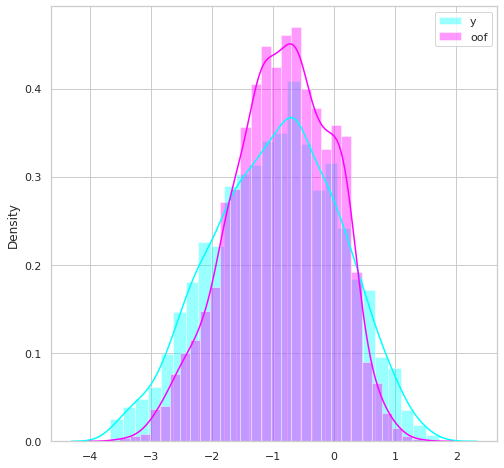

In [9]:
## Main
if not Config.only_inference:
    # training
    print("# ---------- # Start Training # ---------- #")
    oof = train_cv(train)
    oof_df = pd.DataFrame(oof, columns=[Config.target_col])
    oof_df.to_csv(os.path.join(EXP_PREDS, "oof_df.csv"), index=False)

    fold_mask = train["fold"].isin(Config.trn_fold)
    target = train[Config.target_col]

    # get oof score
    score = get_score(target[fold_mask].values, oof[fold_mask])
    logger.info(f"OOF-Score >>>>> {score:.4f}")

    # save result
    fig = plot_result(target[fold_mask].values, oof[fold_mask])
    fig.savefig(os.path.join(EXP_FIG, "regression_result.png"), dpi=300)

# prediction
print("# ---------- # Start Inference # ---------- #")
fold_preds = predict_cv(test)
fold_preds_df = pd.DataFrame()
for i in range(len(fold_preds)):  # single fold ok
    fold_preds_df[f"FOLD{i}"] = fold_preds[i]
fold_preds_df.to_csv(os.path.join(EXP_PREDS, f"fold_preds_df.csv"), index=False)

# make submission
print("# ---------- # Make Submission # ---------- #")
sample_submission["target"] = fold_preds_df.mean(axis=1)
filename = Config.name + ".csv" if COLAB else "submission.csv"
sample_submission.to_csv(os.path.join(SUBMISSION, filename), index=False)